In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [3]:
!wget -nc --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
df.userId = pd.Categorical(df.userId)
df['new_user_id']= df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id']= df.movieId.cat.codes

In [7]:
df

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49
...,...,...,...,...,...,...
20000258,138493,68954,4.5,1258126920,138492,13754
20000259,138493,69526,4.5,1259865108,138492,13862
20000260,138493,69644,3.0,1260209457,138492,13875
20000261,138493,70286,5.0,1258126944,138492,13993


In [8]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

N = len(set(user_ids))
M = len(set(movie_ids))

D =10 # What does this value shows?

In [9]:
user_ids

array([     0,      0,      0, ..., 138492, 138492, 138492], dtype=int32)

In [10]:
movie_ids

array([    1,    28,    31, ..., 13875, 13993, 14277], dtype=int16)

In [11]:
ratings

array([1. , 1. , 1. , ..., 0.5, 2.5, 0. ])

In [12]:
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
        
        # initial the weights since N(0,1) leas to poor results
        self.u_emb.weight.data= nn.Parameter(torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data= nn.Parameter(torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
        
    def forward(self, u, m):
        u = self.u_emb(u)
        m = self.m_emb(m)
        out = torch.cat((u,m), 1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.08, momentum = 0.9) 

In [16]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [17]:
user_ids, movie_ids, ratings

(array([53444, 63780, 20754, ..., 86217, 98780, 64100], dtype=int32),
 array([ 1159, 22016,  4073, ...,  4821, 12328,  3663], dtype=int16),
 array([-1.5,  2. ,  1.5, ...,  1.5,  0.5,  1. ]))

In [18]:
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings).long()

In [19]:
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain],
)
test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:],
)

In [20]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
def batch_gd(model, criterion, optimizer, n_epochs = 200 ):
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    for it in range(n_epochs):
        train_loss = []
        for users, movies, targets in train_loader:
            targets = targets.view(-1,1).float()
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        
        test_loss = []
        for users, movies, targets in test_loader:
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            targets = targets.view(-1,1).float()
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        if (it +1) %1 == 0:
            print(f'Epoch {it+1}/{n_epochs}, Train Loss {loss.item():.4f}, Test Loss {test_loss.item():.4f}')
    return train_losses, test_losses

%prun train_losses, test_losses = batch_gd(model, criterion, optimizer, 25)

Epoch 1/25, Train Loss 0.5542, Test Loss 0.5571
Epoch 2/25, Train Loss 0.5353, Test Loss 0.5490
Epoch 3/25, Train Loss 0.5364, Test Loss 0.5427
Epoch 4/25, Train Loss 0.5340, Test Loss 0.5359
Epoch 5/25, Train Loss 0.5173, Test Loss 0.5287
Epoch 6/25, Train Loss 0.5124, Test Loss 0.5252
Epoch 7/25, Train Loss 0.4984, Test Loss 0.5218
Epoch 8/25, Train Loss 0.5062, Test Loss 0.5206
Epoch 9/25, Train Loss 0.5122, Test Loss 0.5202
Epoch 10/25, Train Loss 0.5000, Test Loss 0.5182
Epoch 11/25, Train Loss 0.5049, Test Loss 0.5198
Epoch 12/25, Train Loss 0.5110, Test Loss 0.5190
Epoch 13/25, Train Loss 0.4898, Test Loss 0.5169
Epoch 14/25, Train Loss 0.5005, Test Loss 0.5160
Epoch 15/25, Train Loss 0.4960, Test Loss 0.5161
Epoch 16/25, Train Loss 0.4995, Test Loss 0.5163
Epoch 17/25, Train Loss 0.5010, Test Loss 0.5156
Epoch 18/25, Train Loss 0.4984, Test Loss 0.5157
Epoch 19/25, Train Loss 0.4918, Test Loss 0.5155
Epoch 20/25, Train Loss 0.4992, Test Loss 0.5158
Epoch 21/25, Train Loss 0.508

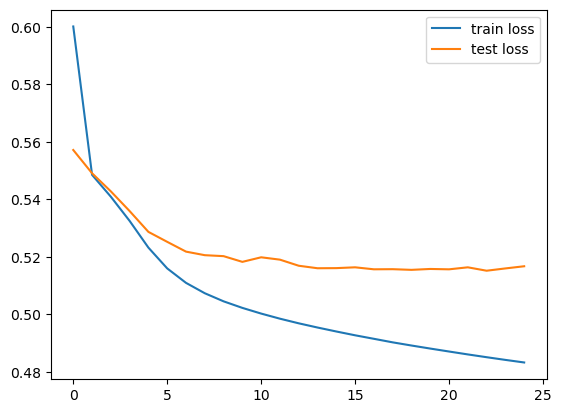

In [22]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [34]:
watched_movie_ids = df[df.new_user_id ==1].new_movie_id.values

In [49]:
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [50]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [51]:
potential_movie_ids.shape

(26683,)

In [52]:
len(set(potential_movie_ids))

26683

In [53]:
user_id_to_recommend = np.ones_like(potential_movie_ids)
# array([1, 1, 1, ..., 1, 1, 1], dtype=int16)
## If we want to do prediction for use 2, we have to multiply all elements to 2:
# array([2, 2, 2, ..., 2, 2, 2], dtype=int16)
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

print(predictions)
predictions_np = predictions.cpu().numpy().flatten()
sort_idx = np.argsort(-predictions_np)
predictions_np


tensor([[0.9739],
        [1.1697],
        [1.3033],
        ...,
        [1.2656],
        [1.4488],
        [1.3953]], device='cuda:0')


array([0.9739217, 1.1696584, 1.3032501, ..., 1.2656298, 1.4488077,
       1.395253 ], dtype=float32)

In [45]:
sort_idx

array([19118, 17628,  2589, ...,  6978,  8994, 13520])

In [46]:
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 18828 score: 2.145982
movie: 21498 score: 2.1166813
movie: 18484 score: 2.0079632
movie: 12281 score: 2.001104
movie: 24660 score: 1.9752045
movie: 24223 score: 1.9620216
movie: 16235 score: 1.9517877
movie: 22369 score: 1.9456043
movie: 6666 score: 1.9390287
movie: 14750 score: 1.938972


In [47]:
user_id_to_recommend

array([1, 1, 1, ..., 1, 1, 1], dtype=int16)

In [48]:
len(user_id_to_recommend)

26683